「使用データセット」
Chest X-Ray Images (Pneumonia)  
5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).  
link: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data

「参照notebook」
このnotebookのアーキテクチャを参考にしています。
https://www.kaggle.com/code/momomooo/efficientnet-chest-x-ray-classification/notebook

「アーキテクチャ」
input (None, 600, 600, 3)  
efficientnet-b7 (weights='imagenet')  
GlobalAveragePooling2D()  
BatchNormalization()  
Dropout(0.4)  
Dense(1)  
BatchNormalization  
Activation('sigmoid')  

「確認済み動作環境」  
python==3.10.12  
pandas==1.5.3  
matplotlib==3.7.1  
scikit-learn==1.2.2  
tensorflow==2.13.0  
efficientnet==1.1.1  
numpy==1.23.5  

In [2]:
!pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.4 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [7]:
IMG_SIZE = 600
BATCH = 32
SEED = 42

# データフレーム作成
---

In [8]:
import pandas as pd
import numpy as np
import glob
import os

In [9]:
main_path = '/content/drive/MyDrive/bigData/chest_xray/'

train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")


train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

In [10]:
df_train.head()

,class,image
0,Normal,/content/drive/MyDrive/bigData/chest_xray/trai...
1,Normal,/content/drive/MyDrive/bigData/chest_xray/trai...
2,Normal,/content/drive/MyDrive/bigData/chest_xray/trai...
3,Normal,/content/drive/MyDrive/bigData/chest_xray/trai...
4,Normal,/content/drive/MyDrive/bigData/chest_xray/trai...


In [11]:
df_test.head()

,class,image
0,Normal,/content/drive/MyDrive/bigData/chest_xray/test...
1,Normal,/content/drive/MyDrive/bigData/chest_xray/test...
2,Normal,/content/drive/MyDrive/bigData/chest_xray/test...
3,Normal,/content/drive/MyDrive/bigData/chest_xray/test...
4,Normal,/content/drive/MyDrive/bigData/chest_xray/test...


# 学習データから訓練(train)データと検証(Validation)データを8:2で分割
---

In [12]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = SEED, stratify = df_train['class'])

# データ前処理、データセット生成
---

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  #rotation_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)


val_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             #directory=train_path, #dataframe contains the full paths
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            #directory=train_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = val_datagen.flow_from_dataframe(df_test,
                                            #directory=test_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

Found 4172 validated image filenames belonging to 2 classes.
Found 1044 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


1枚表示してみる

画像枚数: 624
入力index番号: 21


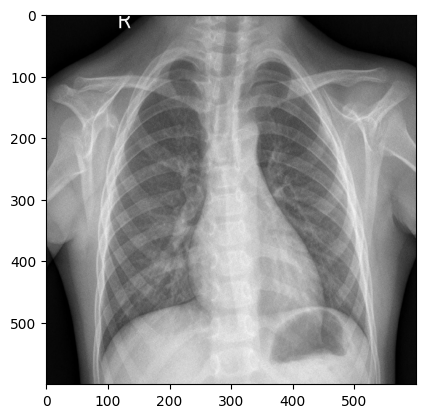

In [14]:
import matplotlib.pyplot as plt

print(f'画像枚数: {ds_test.n}')

# 見たい画像のインデックス番号を指定する。
index = 21
medical_image = ds_test[index][0]
print(f'入力index番号: {index}')
plt.imshow(medical_image[0])

# EfficientNet(出力をカスタム)を実装
---

In [ ]:
'''
既存の学習済みモデルを使用する際には、
レイヤーがネストしないようにする事が望ましい。

ネストしている畳み込みレイヤーに対してCAMを出力しようとした時、
計算グラフが繋がらないケースがあるため。
'''

from tensorflow.keras import layers, Model, metrics
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
import efficientnet.tfkeras as efn
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, BatchNormalization, Dense, Activation, Conv2D


input_shape = (600, 600, 3)

# EfficientNetB7 モデルをロード
pretrained_model_B7 = efn.EfficientNetB7(weights='imagenet', input_shape=input_shape, include_top=False)

input_tensor = pretrained_model_B7.input
output_tensor = pretrained_model_B7.output

# 新たに追加。
x = Conv2D(filters=128, kernel_size=(3,3), activation='relu')(output_tensor)

x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(1)(x)
x = BatchNormalization()(x)
x = Activation('sigmoid')(x)


# トレーニング可能なレイヤーを設定
set_trainable = False
for layer in pretrained_model_B7.layers:
    if layer.name == 'block7c_project_conv':
        set_trainable = True
    # if layer.name == 'top_conv':
        # set_trainable = True
    layer.trainable = set_trainable


# モデルをコンパイル
model = Model(inputs=input_tensor, outputs=x)
model.compile(loss=binary_crossentropy,
                  optimizer=Adam(learning_rate=1e-3),
                  metrics=[metrics.AUC(name='auc'), 'accuracy'])


258434480/258434480 [==============================] - 3s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 600, 600, 3)]        0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 300, 300, 64)         1728      ['input_2[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 300, 300, 64)         256       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, 300, 300, 64)         0         ['stem_bn[0][0]']         

学習開始

In [ ]:
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor='val_auc', mode='max', patience=8,
                                              verbose=1, min_delta=0.0001, restore_best_weights=True)

history = model.fit(ds_train,
                    steps_per_epoch=ds_train.samples//BATCH,
                    epochs = 10,
                    validation_data=ds_val,
                    validation_steps=ds_val.samples//BATCH,
                    callbacks= [es_callback],
                    verbose=1)

Epoch 1/10
130/130 [==============================] - 941s 7s/step - loss: 0.5221 - auc: 0.8956 - accuracy: 0.7773 - val_loss: 0.2960 - val_auc: 0.9808 - val_accuracy: 0.9297
Epoch 2/10
130/130 [==============================] - 678s 5s/step - loss: 0.4380 - auc: 0.9484 - accuracy: 0.8623 - val_loss: 0.2969 - val_auc: 0.9899 - val_accuracy: 0.9365
Epoch 3/10
130/130 [==============================] - 664s 5s/step - loss: 0.3943 - auc: 0.9578 - accuracy: 0.8836 - val_loss: 0.3064 - val_auc: 0.9914 - val_accuracy: 0.9443
Epoch 4/10
130/130 [==============================] - 601s 5s/step - loss: 0.3601 - auc: 0.9652 - accuracy: 0.9012 - val_loss: 0.2871 - val_auc: 0.9927 - val_accuracy: 0.9414
Epoch 5/10
130/130 [==============================] - 655s 5s/step - loss: 0.3314 - auc: 0.9673 - accuracy: 0.9106 - val_loss: 0.3125 - val_auc: 0.9927 - val_accuracy: 0.9238
Epoch 6/10
130/130 [==============================] - 595s 5s/step - loss: 0.3049 - auc: 0.9737 - accuracy: 0.9263 - val_loss

精度を検証

In [ ]:
predictions = model.predict(ds_test)

624/624 [==============================] - 188s 284ms/step


In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(ds_test.labels, np.round(predictions))
print(f'The accuracy is {accuracy}')

The accuracy is 0.9198717948717948


モデルを保存

In [ ]:
model.save('/content/drive/MyDrive/ColabNotebooks/models/efficientNet_xray4.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# grad-CAMの出力
---

学習済みモデルをロード

In [5]:
from tensorflow.keras.models import load_model

# you need A pre-trained efficientNet model.
import efficientnet.tfkeras as efn


model = load_model("/content/drive/MyDrive/ColabNotebooks/models/efficientNet_xray4.h5")

In [ ]:
predictions = model.predict(ds_test)

624/624 [==============================] - 310s 477ms/step


In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(ds_test.labels, np.round(predictions))
print(f'The accuracy is {accuracy}')

The accuracy is 0.8958333333333334


入力画像を準備する。

(1, 600, 600, 3)


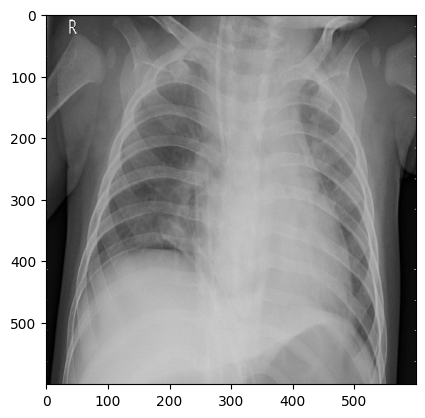

In [18]:
import tensorflow as tf
import matplotlib.pyplot as plt



# 入力する画像のインデックス指定
idx = 556
input_img = ds_test[idx][0]
# NumPy配列をテンソルに変換
input_img_tensor = tf.convert_to_tensor(input_img.reshape(1, 600, 600, 3))
# 中身を確認
print(input_img.shape)
plt.imshow(input_img[0])

intermediate_modelを作成し、入力画像を予測。  
計算過程をtapeに記録する。

In [19]:
from tensorflow.keras import Model

# target_layer = model.get_layer("top_conv")
# target_layer = model.get_layer("conv2d")
target_layer = model.get_layer("block7c_project_conv")
intermediate_model = Model(inputs=[model.inputs], outputs=[target_layer.output, model.output])
with tf.GradientTape() as tape:
    tape.watch(input_img_tensor)  # ここでテンソルをwatch
    conv_output, predictions = intermediate_model(input_img_tensor)
    class_idx = np.argmax(predictions[0])
    loss = predictions[:, class_idx]

print(loss)

tf.Tensor([0.92196935], shape=(1,), dtype=float32)


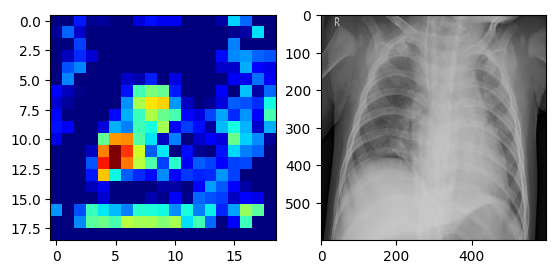

In [20]:
# 勾配を取得
# 通常の勾配の計算(誤差を重みで微分)とは異なり、grad_CAMでは、対象クラスの誤差を特徴マップで微分している。
grads = tape.gradient(loss, conv_output)[0]

# グローバル平均プーリング
# ここでのweights(重み)は、通常の機械学習の文脈における重みではなく、
# Grad-CAMの文脈で特定の特徴マップがどれだけ重要であるかを示す量。
weights = np.mean(grads, axis=(0, 1))

# Grad-CAMの計算
# conv_output[0]はバッチのindex0番目に対応している。今回は１枚のみなので[0]のみ存在している。
cam = np.dot(conv_output[0], weights)
cam = np.maximum(cam, 0)  # ReLU
cam = cam / cam.max()  # 正規化

# 可視化
plt.subplot(121)
plt.imshow(cam, cmap="jet")

plt.subplot(122)
plt.imshow(input_img[0], cmap='gray')

plt.show()

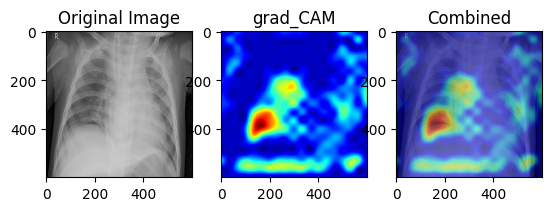

In [21]:
from scipy.ndimage import zoom

# 50x50の特徴マップを224x224にアップサンプリング
zoom_factor = 600 / 19  # 600: ターゲットのサイズ, 19: 元のサイズ
cam_resized = zoom(cam, zoom_factor)

# grad_CAMの位置を調整する。
# shift_x, shift_y = 4, 0  # ずらすピクセル数
# cam_resized = np.roll(cam_resized, shift_x, axis=0)
# cam_resized = np.roll(cam_resized, shift_y, axis=1)

# プロット
plt.subplot(131)
plt.title("Original Image")
plt.imshow(input_img[0], cmap="gray")

plt.subplot(132)
plt.title("grad_CAM")
plt.imshow(cam_resized, cmap="jet")

plt.subplot(133)
plt.title("Combined")
plt.imshow(input_img[0], cmap="gray")
plt.imshow(cam_resized, cmap='jet', alpha=0.5)

plt.show()

# カラーマップ作成、画像を合成
---

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

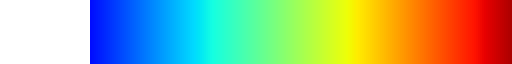

In [23]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

cmap = plt.get_cmap('jet')
cmaplist = [cmap(i) for i in range(cmap.N)]

# 範囲を変更
shift_amount = 10
new_cmaplist = [(1, 1, 1, 0.0) for _ in range(shift_amount)] + cmaplist[:-shift_amount]


for i in range(45):
    new_cmaplist[i] = (1, 1, 1, 0.0)  # (R, G, B, Alpha)


cmap_custom = mcolors.LinearSegmentedColormap.from_list('custom_cmap', new_cmaplist, cmap.N)
cmap_custom

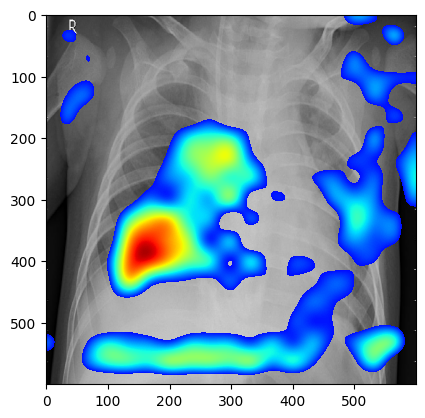

In [24]:
import matplotlib.colors as mcolors


# 元の画像
plt.imshow(input_img[0], cmap='gray')
# CAMを透過してオーバーレイ表示
plt.imshow(cam_resized, cmap=cmap_custom, alpha=1, vmin=0)

plt.show()